In [77]:
import os
import shutil

# Directory containing the images
image_dir = 'data/train'

# Create subdirectories for each image and move the image into it
for image in os.listdir(image_dir):
    if image.endswith('.png'):
        # Create a subdirectory named after the image (without the extension)
        subdir = os.path.join(image_dir, os.path.splitext(image)[0])
        os.makedirs(subdir, exist_ok=True)
        
        # Move the image into the subdirectory
        src_path = os.path.join(image_dir, image)
        dst_path = os.path.join(subdir, image)
        shutil.move(src_path, dst_path)

print('Subdirectories created and images moved.')


Subdirectories created and images moved.


In [78]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

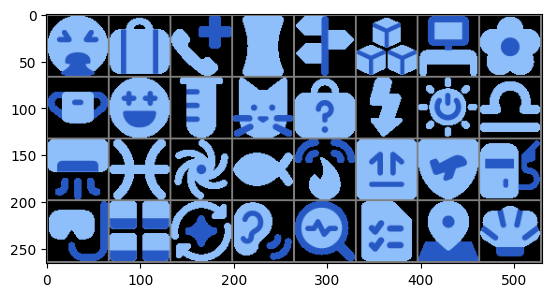

  245    29   183    77   257   140   285   103   105   243   263    53   158   101     0   298   128   289   108    68    97    38    22   110   249   198    13    88   121   261   154   216


In [79]:
# Setting the transform to normalize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the dataset from the specified folder and applying the transform
dataset = ImageFolder(root='data/train', transform=transform)

# Defining the batch size
batch_size = 32

# Creating a DataLoader to load the data in batches
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Extracting the class names from the dataset
classes = tuple(item[1] for item in dataset.class_to_idx.items())

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Getting some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Showing the images
imshow(make_grid(images))
# Printing the labels
print(' '.join(f'{classes[labels[j]]:5}' for j in range(batch_size)))

In [80]:
# Defining the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiating the model
net = Net()

In [81]:
# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Lists to store loss and accuracy for plotting
training_loss = []
training_accuracy = []

# Training the model
for epoch in range(2):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:    # Print and record every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            training_loss.append(running_loss / 100)
            training_accuracy.append(100 * correct / total)
            running_loss = 0.0

print('Finished Training')

Finished Training


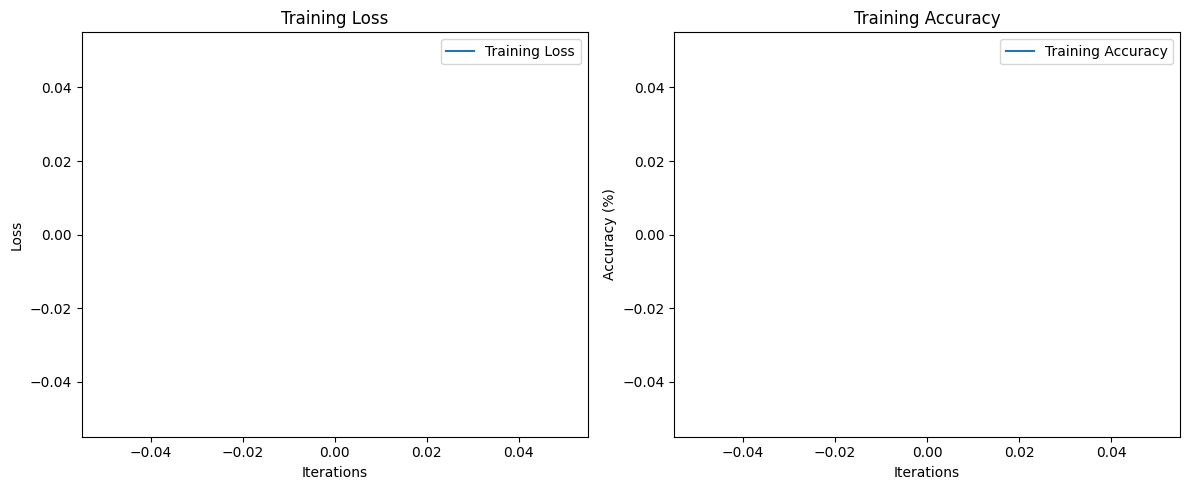

In [82]:
# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [83]:
# Saving the trained model
PATH = 'models/model.pth'
torch.save(net.state_dict(), PATH)

# Testing the model
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

RuntimeError: Parent directory models does not exist.

In [ ]:

# Calculating accuracy for each class
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print(f'Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]:.2f} %')
